In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 100
import glob
import os

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.lattice import Site, Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel, CouplingMPOModel
from tenpy.linalg import np_conserved as npc
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite

tenpy.tools.misc.setup_logging(to_stdout="INFO", to_file=None)

# H

$$
H = \sum_i \left(\frac{\mathtt{\Omega}}{2} \sigma^{-}_i + \frac{\mathtt{\Omega^*}}{2} \sigma^{+}_i \right) - \Delta \left(S^z_i+\frac{1}{2}\right)
                 + \sum_{i < j} \frac{V_0}{|j-i|^6} \left(S^z_i+\frac{1}{2} \right)\left(S^z_j+\frac{1}{2} \right)
$$

In [3]:
site = SpinHalfSite(conserve='None')
site.valid_opname('Sigma_minus')

False

In [4]:
site.valid_opname

<bound method Site.valid_opname of SpinHalfSite('None')>

In [29]:
site.Sz.to_ndarray()

array([[ 0.5,  0. ],
       [ 0. , -0.5]])

In [31]:
site.Sm.to_ndarray()

array([[0., 0.],
       [1., 0.]])

In [3]:
def cij(SzSz, i, j):
    return 4*SzSz[i,j]

def cdx(SzSz, dx):
    L = len(SzSz)
    c = 0
    for i in range(L-dx):
        c += cij(SzSz, i, i+dx)
    return c/L

# Rydberg model 

In [3]:
class RydbergChain(CouplingModel, MPOModel):
    r"""Spin-1/2 Rydberg chain

    .. math ::
        H = \sum_i \left(\frac{\mathtt{\Omega}}{2} S^{-}_i + \frac{\mathtt{\Omega^*}}{2} S^{+}_i \right) - \Delta \left(S^z_i+\frac{1}{2}\right)
                 + \sum_{i < j} V_{ij} \left(S^z_i+\frac{1}{2} \right)\left(S^z_j+\frac{1}{2} \right)

    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.

    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`RydbergChain` below.

    Options
    -------
    .. cfg:config :: RydbergChain
        :include: CouplingMPOModel

        L : int
            Length of the chain.
        Omega, Delta, V0 : float | array
            Coupling as defined for the Hamiltonian above.
        bc_MPS : {'finite' | 'infinte'}
            MPS boundary conditions. Coupling boundary conditions are chosen appropriately.

    """
    def __init__(self, model_params):
        # 0) read out/set default parameters
        model_params = asConfig(model_params, "RydbergChain")
        L = model_params.get('L', 2)
        Omega = model_params.get('Omega', 1.)
        Delta = model_params.get('Delta', 1.)
        V0 = model_params.get('V0', 0.)
        bc_MPS = model_params.get('bc_MPS', 'finite')
        site = SpinHalfSite(conserve='None')
        # 4) lattice
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)
        # 5) initialize CouplingModel
        CouplingModel.__init__(self, lat)
        # 6) add terms of the Hamiltonian
        # (u is always 0 as we have only one site in the unit cell)
        self.add_onsite(-Delta, 0, 'Sz')
        self.add_onsite(-Delta, 0, 'Id')
        self.add_onsite(Omega/2, 0, 'Sm', plus_hc=True)
        self.add_coupling(V0, 0, 'Sz', 0, 'Sz', 1)
        self.add_coupling(V0/2, 0, 'Sz', 0, 'Id', 1)
        self.add_coupling(V0/2, 0, 'Id', 0, 'Sz', 1)
        self.add_coupling(V0/4, 0, 'Id', 0, 'Id', 1)
        self.add_coupling(V0/64, 0, 'Sz', 0, 'Sz', 2)
        self.add_coupling(V0/128, 0, 'Sz', 0, 'Id', 2)
        self.add_coupling(V0/128, 0, 'Id', 0, 'Sz', 2)
        self.add_coupling(V0/256, 0, 'Id', 0, 'Id', 2)
        self.add_coupling(V0/729, 0, 'Sz', 0, 'Sz', 3)
        self.add_coupling(V0/1458, 0, 'Sz', 0, 'Id', 3)
        self.add_coupling(V0/1458, 0, 'Id', 0, 'Sz', 3)
        self.add_coupling(V0/2916, 0, 'Id', 0, 'Id', 3)
        # 7) initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO())


In [28]:
3**6

729

In [5]:
L = 80

In [6]:
model_params = {
    'Omega': 1., 'Delta': 0, 'V0': 2., 'L': L, 'bc_MPS': 'finite',
}

M = RydbergChain(model_params)

INFO    : RydbergChain: reading 'L'=80
INFO    : RydbergChain: reading 'Omega'=1.0
INFO    : RydbergChain: reading 'Delta'=0
INFO    : RydbergChain: reading 'V0'=2.0
INFO    : RydbergChain: reading 'bc_MPS'='finite'


In [7]:
psi = MPS.from_lat_product_state(M.lat, [['down']])

In [8]:
dmrg_params = {
    'mixer': None,  # setting this to True helps to escape local minima
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': 100,
        'svd_min': 1.e-10,
    },
    'verbose': True,
    'combine': True
}
eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
E, psi = eng.run() # the main work; modifies psi in place

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'combine'=True
INFO    : TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : checkpoint after sweep 1
energy=-61.9325851199268698, max S=0.0572697304060914, age=80, norm_err=5.4e-02
Current memory usage 137508.0MB, wall time: 0.8s
Delta E = nan, Delta S = 4.2147e-02 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 8.5265e-14
chi: 4
INFO    : Running sweep with optimization
INFO    : lanczos_params: setting 'P_tol'=5.0000000000000005e-22
INFO    : checkpoint after sweep 2
energy=-61.9325851245094583, max S=0.0478695871376030, age=80, norm_err=2.4e-10
Current memory usage 177968.0MB, wall time: 6.0s
Delta E = -4.5826e-09, Delta S = -1.1656e-04 (per sweep)
max trunc_err = 6

In [9]:
# the ground state energy was directly returned by dmrg.run()
print("ground state energy = ", E)

# there are other ways to extract the energy from psi:
E1 = M.H_MPO.expectation_value(psi)  # based on the MPO
# E2 = np.sum(M.bond_energies(psi))  # based on bond terms of H, works only for a NearestNeighborModel
assert abs(E-E1) < 1.e-10

ground state energy =  -61.9325851245101


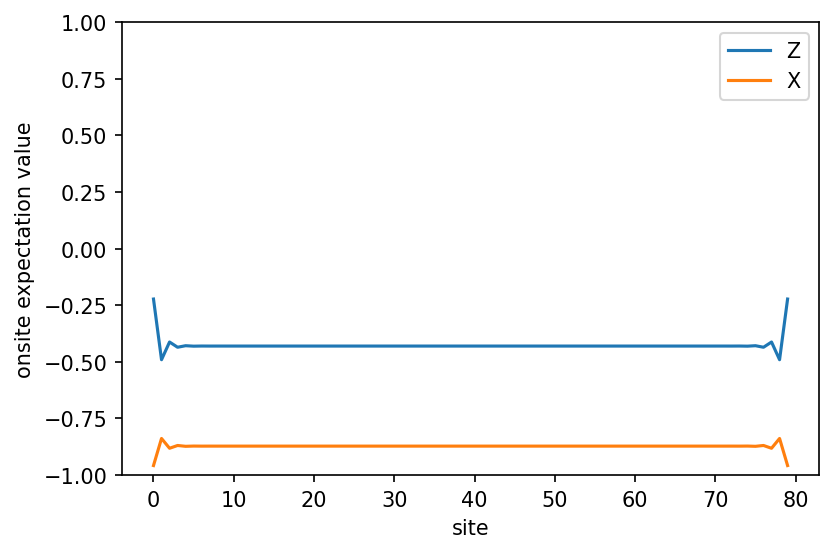

In [11]:
# onsite expectation values

X = psi.expectation_value("Sigmax")
Z = psi.expectation_value("Sigmaz")
x = np.arange(psi.L)
plt.figure()
plt.plot(x, Z, label="Z")
plt.plot(x, X, label="X")   # note: it's clear that this is zero due to charge conservation!
plt.xlabel("site")
plt.ylabel("onsite expectation value")
plt.legend()
plt.ylim([-1,1])
plt.show()

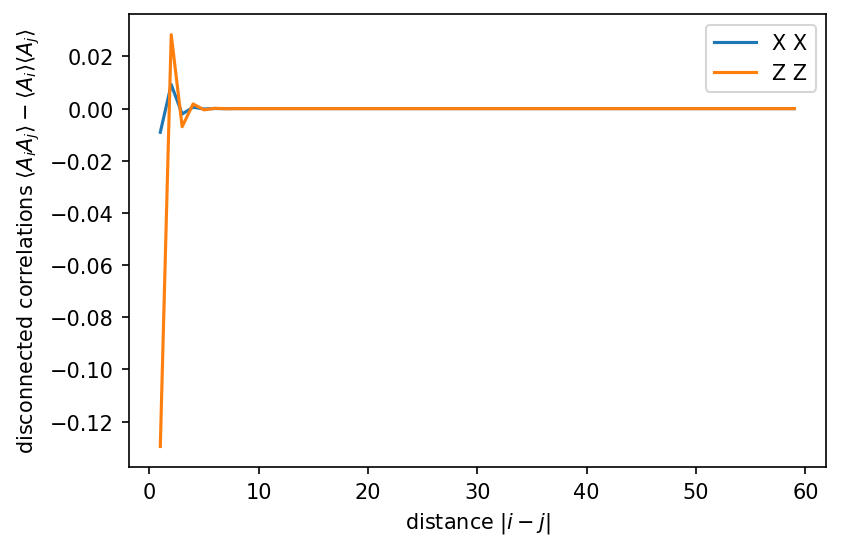

In [12]:
# correlation functions

i0 = psi.L // 4  # for fixed `i`
j = np.arange(i0 + 1, psi.L)
XX = psi.term_correlation_function_right([("Sigmax", 0)], [("Sigmax", 0)], i_L=i0, j_R=j)
XX_disc = XX - X[i0] * X[j]
ZZ = psi.term_correlation_function_right([("Sigmaz", 0)], [("Sigmaz", 0)], i_L=i0, j_R=j)
ZZ_disc = ZZ - Z[i0] * Z[j]

dx = j - i0
plt.figure()
plt.plot(dx, XX_disc, label="X X")
plt.plot(dx, ZZ_disc, label="Z Z")
plt.xlabel(r"distance $|i-j|$")
plt.ylabel(r"disconnected correlations $\langle A_i A_j\rangle - \langle A_i \rangle\langle A_j\rangle$")
plt.legend()
# plt.loglog()
# plt.ylim([1e-20,2e-2])
plt.show()

extraced central charge -0.00000 with residuum 8.12e-26
(Expect central charge = 0.5 for the transverse field Ising model.)


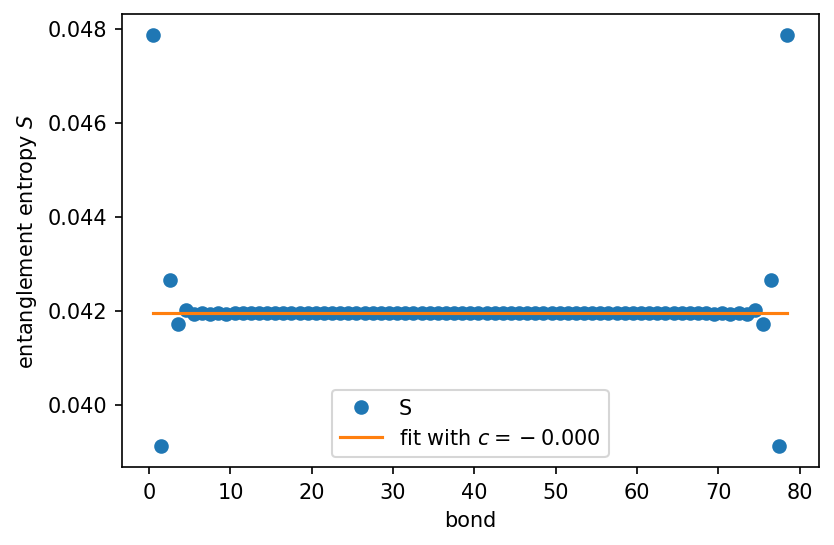

In [13]:
S = psi.entanglement_entropy()

bonds = np.arange(0.5, psi.L-1)
plt.plot(bonds, S, 'o', label="S")

# preform fit to extract the central charge
central_charge, const, res = tenpy.tools.fit.central_charge_from_S_profile(psi)
fit = tenpy.tools.fit.entropy_profile_from_CFT(bonds + 0.5, psi.L, central_charge, const)
print(f"extraced central charge {central_charge:.5f} with residuum {res:.2e}")
print("(Expect central charge = 0.5 for the transverse field Ising model.)")
plt.plot(bonds, fit, label=f"fit with $c={central_charge:.3f}$")
plt.xlabel("bond")
plt.ylabel("entanglement entropy $S$")
plt.legend()
plt.show()

# ground state search, reproducing 51 atom simulator crystals

In [5]:
def getSimParams(L, V0, Delta, Omega, outfile, stdout=None, printratios=False):
    if (printratios):
        print('ratios:\n {:.2f}\n {:.2f}\n {:.2f}'.format(V0/(64*Delta), Delta/Omega, 729*Omega/V0))
    simulation_params = {'simulation_class': 'GroundStateSearch',
        'output_filename': outfile,
        'overwrite_output' : True,
        'skip_if_output_exists' : False,
        'log_params': {'to_file': None, 'to_stdout': stdout},
        'model_class': 'RydbergChain',
        'model_params': {'Omega': Omega,
        'Delta': Delta,
        'V0': V0,
        'L': L,
        'bc_MPS': 'finite'},
        'initial_state_params': {'method': 'lat_product_state',
        'product_state': [['down']]},
        'algorithm_class': 'TwoSiteDMRGEngine',
        'algorithm_params': {'trunc_params': {'svd_min': 1e-10, 'chi_max': 100},
        'mixer': True},
        'connect_measurements': [['tenpy.simulations.measurement',
        'onsite_expectation_value',
        {'opname': 'Sz'}],
        ['tenpy.simulations.measurement',
        'psi_method',
        {'key': '<Sz_i Sz_j>',
        'method': 'correlation_function',
        'ops1': 'Sz',
        'ops2': 'Sz'}]]}
    return simulation_params

## Z2

In [7]:
L = 31
V0 = 20
Delta = 5
Omega = 0.5
output_name_Z2 = 'results_Z2.h5'
simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z2)

In [8]:
tenpy.run_simulation(**simulation_params);

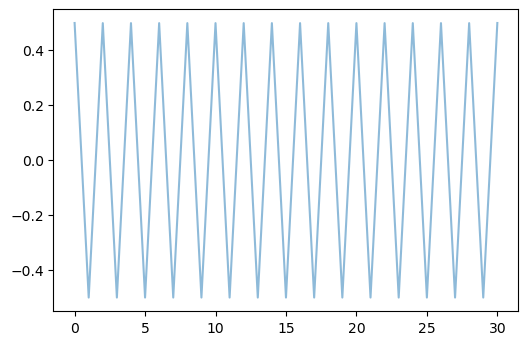

In [9]:
results_Z2 = tenpy.tools.hdf5_io.load(output_name_Z2)

Sz = results_Z2['measurements']['<Sz>']
SzSz = results_Z2['measurements']['<Sz_i Sz_j>']

plt.plot(Sz[1], alpha=0.5)

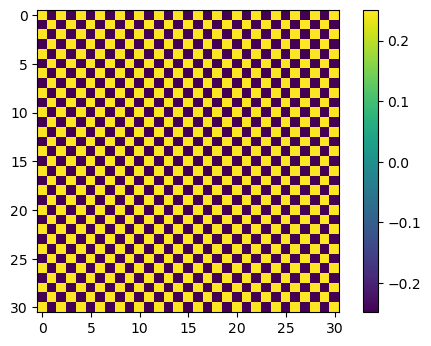

In [10]:
plt.imshow(SzSz[1])
plt.colorbar()

In [113]:
cs = []
for dx in range(int(L/2)):
    cs.append(cdx(SzSz[1],dx))
cs = np.array(cs)

Text(0, 0.5, 'corr')

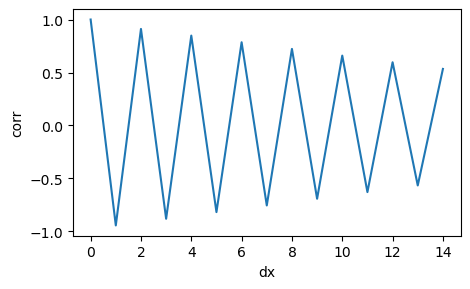

In [114]:
fig, ax = plt.subplots(figsize=[5,3])
plt.plot(cs)
plt.xlabel('dx')
plt.ylabel('corr')

### matching 51 atom simulator

In [21]:
output_name_Z2 = 'results_Z2_paper.h5'.format(L,V0,Delta,Omega)
L = 13
V0 = 24
Delta = 8
Omega = 60*36/(2*560)
simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z2)

In [22]:
tenpy.run_simulation(**simulation_params);

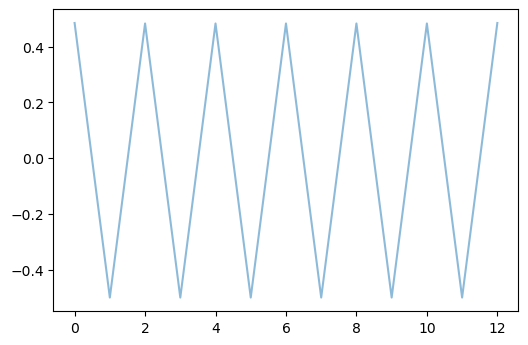

In [23]:
resultsZ2 = tenpy.tools.hdf5_io.load(output_name_Z2)

Sz = resultsZ2['measurements']['<Sz>']
SzSz = resultsZ2['measurements']['<Sz_i Sz_j>']

plt.plot(Sz[1], alpha=0.5)

## Z3

want $V_{i,i+1}, V_{i,i+2} \gg \Delta \gg \Omega \gg V_{i,i+3}$. couplings are $V_0, V_0/64, V_0/729$

hard to reach the $\gg$ conditions

In [134]:
(729/64)**(1/3)

2.25

### matching 51 atom simulator

In [17]:
output_name_Z3 = 'results_Z3.h5'
L = 13
V0 = 414
Delta = 8
Omega = 60*36/(2*560)
simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z3, printratios=True)

ratios:
 0.81
 4.15
 3.40


In [18]:
tenpy.run_simulation(**simulation_params);

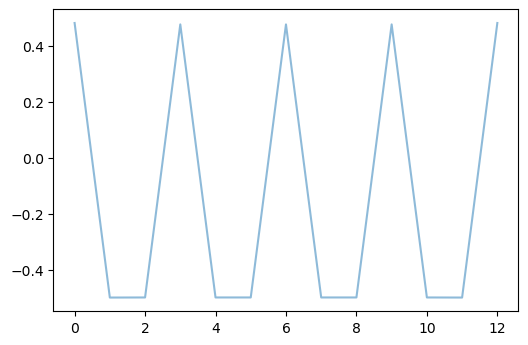

In [19]:
resultsZ3 = tenpy.tools.hdf5_io.load(output_name_Z3)

Sz = resultsZ3['measurements']['<Sz>']
SzSz = resultsZ3['measurements']['<Sz_i Sz_j>']

plt.plot(Sz[1], alpha=0.5)

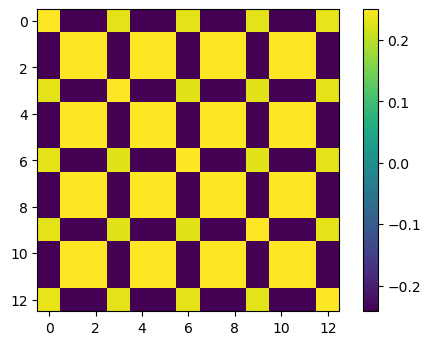

In [20]:
plt.imshow(SzSz[1])
plt.colorbar()

In [15]:
cs = []
for dx in range(int(L/2)):
    cs.append(cdx(SzSz[1],dx))
cs = np.array(cs)

Text(0, 0.5, 'corr')

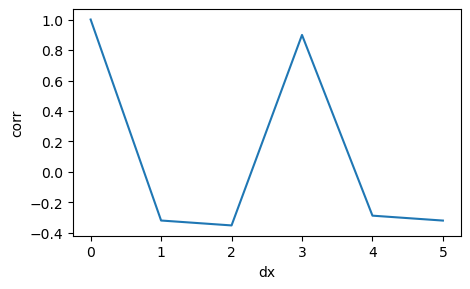

In [16]:
fig, ax = plt.subplots(figsize=[5,3])
plt.plot(cs)
plt.xlabel('dx')
plt.ylabel('corr')

### scan deltas looking for Z3

In [17]:
output_name_Z3 = 'results_Z3.h5'
L = 13
V0 = 500
Deltas = np.linspace(0.5, 10, 15)
Omega = 0.5

In [18]:
Szs = []
SzSzs = []
for d in Deltas:
    print(d)
    simulation_params = getSimParams(L, V0, d, Omega, output_name_Z3)
    tenpy.run_simulation(**simulation_params);
    resultsZ3 = tenpy.tools.hdf5_io.load(output_name_Z3)
    Szs.append(resultsZ3['measurements']['<Sz>'])
    SzSzs.append(resultsZ3['measurements']['<Sz_i Sz_j>'])
Szs = np.array(Szs)
SzSzs = np.array(SzSzs)

0.5
1.1785714285714286
1.8571428571428572
2.5357142857142856
3.2142857142857144
3.8928571428571432
4.571428571428571
5.25
5.928571428571429
6.607142857142858
7.2857142857142865
7.964285714285714
8.642857142857142
9.321428571428571
10.0


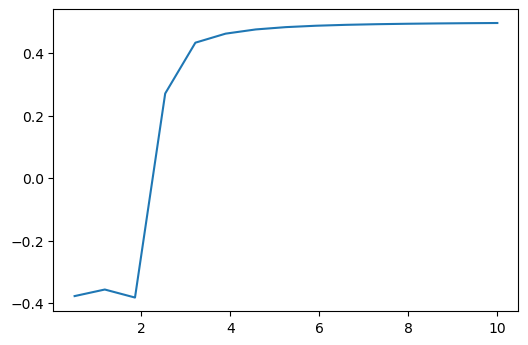

In [157]:
plt.plot(Deltas,Szs[:,1,3])

In [156]:
Deltas[10]

7.2857142857142865

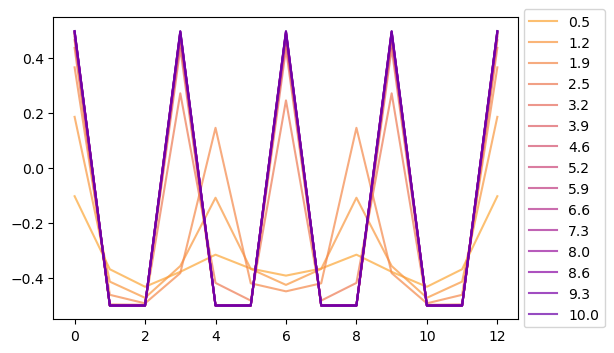

In [192]:
n = len(Deltas)
colors = plt.cm.plasma_r(np.linspace(0.2,0.8,n))

for (i, d) in enumerate(Deltas):
    plt.plot(Szs[i,1,:], color=colors[i], alpha=0.7, label='{:.1f}'.format(d))
plt.legend(bbox_to_anchor=(1.,0.05,0.2,1.0))

Z3 order for $\Delta > 5$, corresponds to ratios

In [198]:
print('ratios:\n {:.2f}\n {:.2f}\n {:.2f}'.format(V0/(64*Deltas[5]), Deltas[5]/Omega, 729*Omega/V0))

ratios:
 2.01
 7.79
 0.73


and at $\Delta$ = 10

In [200]:
print('ratios:\n {:.2f}\n {:.2f}\n {:.2f}'.format(V0/(64*Deltas[-1]), Deltas[-1]/Omega, 729*Omega/V0))

ratios:
 0.78
 20.00
 0.73


Text(0, 0.5, 'corr')

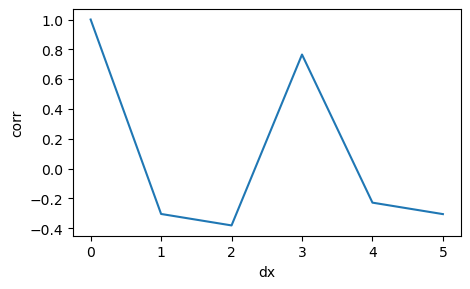

In [189]:
cs = []
for dx in range(int(L/2)):
    cs.append(cdx(SzSzs[-1,1],dx))
cs = np.array(cs)

fig, ax = plt.subplots(figsize=[5,3])
plt.plot(cs)
plt.xlabel('dx')
plt.ylabel('corr')

### with more atoms

In [235]:
output_name_Z3 = 'results_Z3.h5'.format(L,V0,Delta,Omega)
L = 31
V0 = 500
Delta = 10
Omega = 0.5
simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z3, stdout='INFO', printratios=True)

ratios:
 0.78
 20.00
 0.73


In [236]:
tenpy.run_simulation(**simulation_params);

INFO    : simulation class GroundStateSearch
INFO    : output filename: results_Z3.h5
INFO    : GroundStateSearch: reading 'algorithm_params'={'trunc_params': {'svd_min': 1e-10, 'chi_max': 100}, 'mixer': True}
INFO    : GroundStateSearch: reading 'model_class'='RydbergChain'
INFO    : GroundStateSearch: subconfig 'model_params'=Config(<5 options>, 'model_params')
INFO    : model_params: reading 'L'=31
INFO    : model_params: reading 'Omega'=0.5
INFO    : model_params: reading 'Delta'=10
INFO    : model_params: reading 'V0'=500
INFO    : model_params: reading 'bc_MPS'='finite'
INFO    : GroundStateSearch: subconfig 'initial_state_params'=Config(<2 options>, 'initial_state_params')
INFO    : initial_state_params: reading 'method'='lat_product_state'
INFO    : calling InitialStateBuilder.lat_product_state()
INFO    : initial_state_params: reading 'product_state'=[['down']]
INFO    : GroundStateSearch: reading 'algorithm_class'='TwoSiteDMRGEngine'
INFO    : algorithm_params: subconfig 'tru

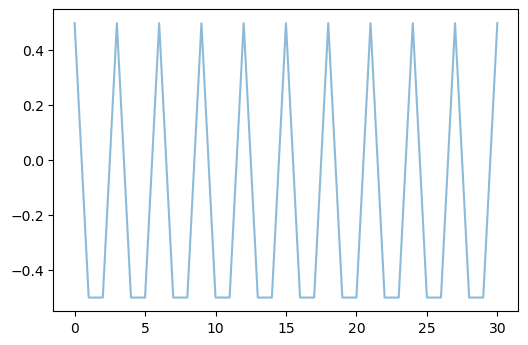

In [237]:
resultsZ3 = tenpy.tools.hdf5_io.load(output_name_Z3)

Sz = resultsZ3['measurements']['<Sz>']
SzSz = resultsZ3['measurements']['<Sz_i Sz_j>']

plt.plot(Sz[1], alpha=0.5)

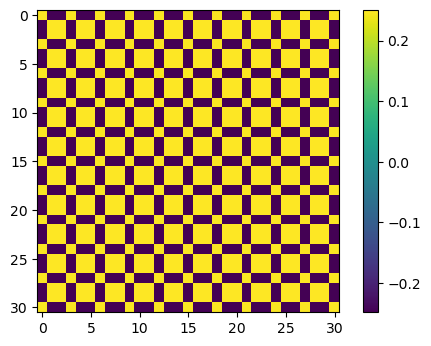

In [238]:
plt.imshow(SzSz[1])
plt.colorbar()

In [239]:
cs = []
for dx in range(int(L/2)):
    cs.append(cdx(SzSz[1],dx))
cs = np.array(cs)

Text(0, 0.5, 'corr')

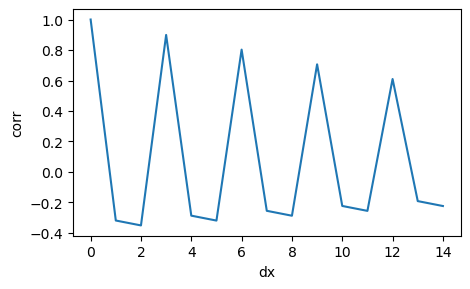

In [240]:
fig, ax = plt.subplots(figsize=[5,3])
plt.plot(cs)
plt.xlabel('dx')
plt.ylabel('corr')

# Z4

## matching

want $V_{i,i+1}, V_{i,i+2} \gg \Delta \gg \Omega \gg V_{i,i+3}$. couplings are $V_0, V_0/64, V_0/729$

In [13]:
output_name_Z4 = 'results_Z4.h5'
L = 13
V0 = 1536
Delta = 6
Omega = 60*36/(2*560)
simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z4, printratios=True)

ratios:
 4.00
 3.11
 0.92


In [14]:
tenpy.run_simulation(**simulation_params);

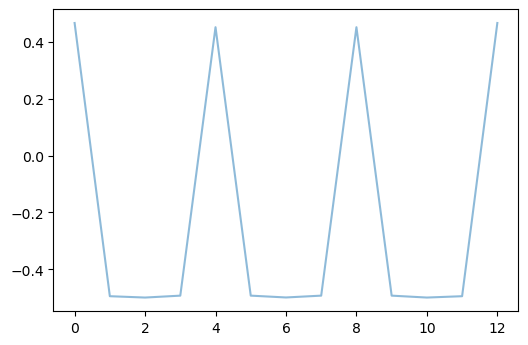

In [15]:
resultsZ4 = tenpy.tools.hdf5_io.load(output_name_Z4)

Sz = resultsZ4['measurements']['<Sz>']
SzSz = resultsZ4['measurements']['<Sz_i Sz_j>']

plt.plot(Sz[1], alpha=0.5)

### scan deltas looking for Z4

In [24]:
output_name_Z4 = 'results_Z4.h5'
L = 13
V0s = np.linspace(500,8000,10)
Delta = 6
Omega = 60*36/(2*560)

In [25]:
Szs = []
SzSzs = []
for V0 in V0s:
    print(V0)
    simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z4)
    tenpy.run_simulation(**simulation_params);
    resultsZ4 = tenpy.tools.hdf5_io.load(output_name_Z4)
    Szs.append(resultsZ4['measurements']['<Sz>'])
    SzSzs.append(resultsZ4['measurements']['<Sz_i Sz_j>'])
Szs = np.array(Szs)
SzSzs = np.array(SzSzs)

500.0
1333.3333333333335
2166.666666666667
3000.0
3833.3333333333335
4666.666666666667
5500.0
6333.333333333334
7166.666666666667
8000.0


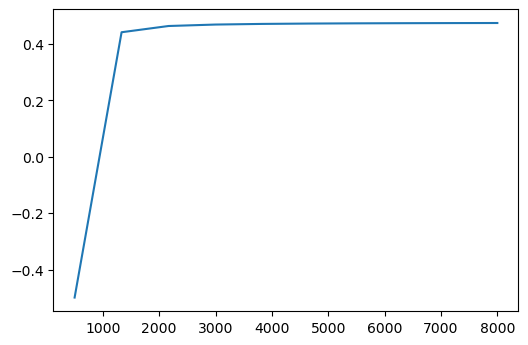

In [26]:
plt.plot(V0s,Szs[:,1,4])

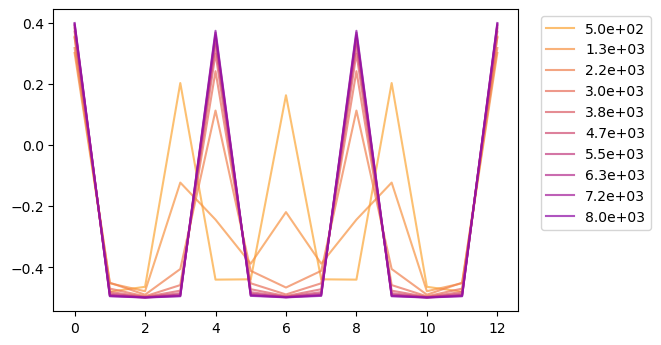

In [61]:
n = len(V0s)
colors = plt.cm.plasma_r(np.linspace(0.2,0.7,n))

for (i, V0) in enumerate(V0s):
    plt.plot(Szs[i,1,:], color=colors[i], alpha=0.7, label='{:.1e}'.format(V0))
plt.legend(bbox_to_anchor=(1.1,0.0,0.2,1.0))

## more atoms

In [256]:
output_name_Z4 = 'results_Z4_lrg.h5'
L = 4*8+1
V0 = 8000
Delta = 20
Omega = 0.5
simulation_params = getSimParams(L, V0, Delta, Omega, output_name_Z4, stdout='INFO', printratios=True)

ratios:
 6.25
 40.00
 0.05


In [257]:
tenpy.run_simulation(**simulation_params);

INFO    : simulation class GroundStateSearch
INFO    : output filename: results_Z4_lrg.h5
INFO    : GroundStateSearch: reading 'algorithm_params'={'trunc_params': {'svd_min': 1e-10, 'chi_max': 100}, 'mixer': True}
INFO    : GroundStateSearch: reading 'model_class'='RydbergChain'
INFO    : GroundStateSearch: subconfig 'model_params'=Config(<5 options>, 'model_params')
INFO    : model_params: reading 'L'=33
INFO    : model_params: reading 'Omega'=0.5
INFO    : model_params: reading 'Delta'=20
INFO    : model_params: reading 'V0'=8000
INFO    : model_params: reading 'bc_MPS'='finite'
INFO    : GroundStateSearch: subconfig 'initial_state_params'=Config(<2 options>, 'initial_state_params')
INFO    : initial_state_params: reading 'method'='lat_product_state'
INFO    : calling InitialStateBuilder.lat_product_state()
INFO    : initial_state_params: reading 'product_state'=[['down']]
INFO    : GroundStateSearch: reading 'algorithm_class'='TwoSiteDMRGEngine'
INFO    : algorithm_params: subconfig

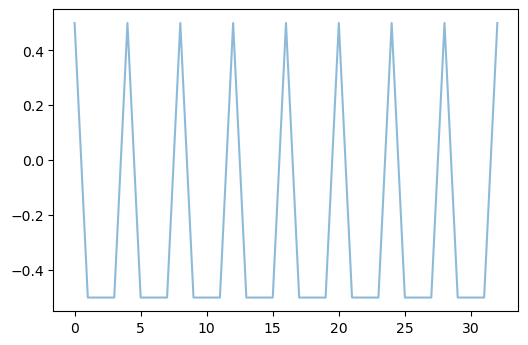

In [258]:
resultsZ4 = tenpy.tools.hdf5_io.load(output_name_Z4)

Sz = resultsZ4['measurements']['<Sz>']
SzSz = resultsZ4['measurements']['<Sz_i Sz_j>']

plt.plot(Sz[1], alpha=0.5)

# dynamics

In [164]:
from tenpy.algorithms import tebd

In [182]:
class RydbergChainNN(CouplingModel, MPOModel, NearestNeighborModel):
    r"""Spin-1/2 Rydberg chain

    The Hamiltonian reads:

    .. math ::
        H = \sum_i \left(\frac{\mathtt{\Omega}}{2} S^{-}_i + \frac{\mathtt{\Omega^*}}{2} S^{+}_i \right) - \Delta \left(S^z_i+\frac{1}{2}\right)
                 + \sum_{i < j} V_{ij} \left(S^z_i+\frac{1}{2} \right)\left(S^z_j+\frac{1}{2} \right)

    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.

    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`RydbergChain` below.

    Options
    -------
    .. cfg:config :: RydbergChain
        :include: CouplingMPOModel

        L : int
            Length of the chain.
        Omega, Delta, V0 : float | array
            Coupling as defined for the Hamiltonian above.
        bc_MPS : {'finite' | 'infinte'}
            MPS boundary conditions. Coupling boundary conditions are chosen appropriately.

    """
    def __init__(self, model_params):
        # 0) read out/set default parameters
        model_params = asConfig(model_params, "RydbergChain")
        L = model_params.get('L', 2)
        Omega = model_params.get('Omega', 1.)
        Delta = model_params.get('Delta', 1.)
        V0 = model_params.get('V0', 0.)
        bc_MPS = model_params.get('bc_MPS', 'finite')
        site = SpinHalfSite(conserve='None')
        # 4) lattice
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)
        # 5) initialize CouplingModel
        CouplingModel.__init__(self, lat)
        # 6) add terms of the Hamiltonian
        # (u is always 0 as we have only one site in the unit cell)
        self.add_onsite(-Delta, 0, 'Sz')
        self.add_onsite(-Delta, 0, 'Id')
        self.add_onsite(Omega, 0, 'Sm', plus_hc=True)
        self.add_coupling(V0, 0, 'Sz', 0, 'Sz', 1)
        self.add_coupling(V0/2, 0, 'Sz', 0, 'Id', 1)
        self.add_coupling(V0/2, 0, 'Id', 0, 'Sz', 1)
        self.add_coupling(V0/4, 0, 'Id', 0, 'Id', 1)
        # 7) initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO())
        NearestNeighborModel.__init__(self, lat, self.calc_H_bond())


In [183]:
L = 30

In [275]:
model_params = {
    'Omega': 1, 'Delta': 0.1, 'V0': 2, 'L': L, 'bc_MPS': 'finite',
}

M = RydbergChainNN(model_params)

INFO    : RydbergChain: reading 'L'=30
INFO    : RydbergChain: reading 'Omega'=1
INFO    : RydbergChain: reading 'Delta'=0.1
INFO    : RydbergChain: reading 'V0'=2
INFO    : RydbergChain: reading 'bc_MPS'='finite'


In [276]:
psi = MPS.from_lat_product_state(M.lat, [['down']])

In [277]:
tebd_params = {
    'N_steps': 1,
    'dt': 0.05,
    'order': 4,
    'trunc_params': {'chi_max': 100, 'svd_min': 1.e-12}
}
eng = tebd.TEBDEngine(psi, M, tebd_params)

INFO    : TEBDEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')


In [278]:
def measurement(eng, data):
    keys = ['t', 'entropy', 'Sx', 'Sz', 'corr_XX', 'corr_ZZ', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['corr_XX'].append(eng.psi.correlation_function('Sigmax', 'Sigmax'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

In [279]:
data = measurement(eng, None)

In [282]:
while eng.evolved_time < 10:
    eng.run()
    measurement(eng, data)

INFO    : --> time=2.050, max(chi)=26, max(S)=0.47807, avg DeltaS=7.9023e-03, since last update: 0.7s
INFO    : --> time=2.100, max(chi)=27, max(S)=0.48404, avg DeltaS=6.7407e-03, since last update: 0.6s
INFO    : --> time=2.150, max(chi)=28, max(S)=0.48862, avg DeltaS=5.5671e-03, since last update: 0.6s
INFO    : --> time=2.200, max(chi)=28, max(S)=0.49196, avg DeltaS=4.4810e-03, since last update: 0.7s
INFO    : --> time=2.250, max(chi)=29, max(S)=0.49421, avg DeltaS=3.5574e-03, since last update: 0.6s
INFO    : --> time=2.300, max(chi)=30, max(S)=0.49653, avg DeltaS=2.8440e-03, since last update: 0.7s
INFO    : --> time=2.350, max(chi)=31, max(S)=0.49886, avg DeltaS=2.3641e-03, since last update: 0.7s
INFO    : --> time=2.400, max(chi)=33, max(S)=0.50106, avg DeltaS=2.1218e-03, since last update: 0.7s
INFO    : --> time=2.450, max(chi)=34, max(S)=0.50342, avg DeltaS=2.1104e-03, since last update: 0.9s
INFO    : --> time=2.500, max(chi)=35, max(S)=0.50623, avg DeltaS=2.3210e-03, sinc

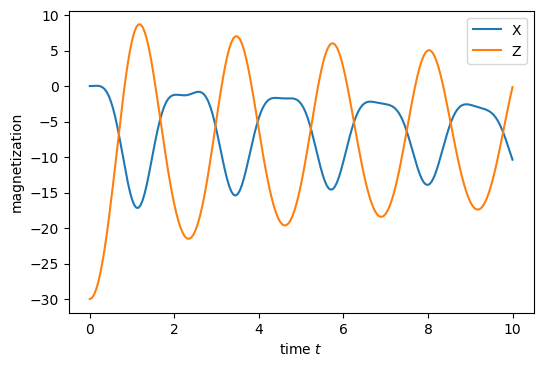

In [283]:
plt.plot(data['t'], np.sum(data['Sx'], axis=1), label="X")
plt.plot(data['t'], np.sum(data['Sz'], axis=1), label="Z")

plt.xlabel('time $t$')
plt.ylabel('magnetization')
plt.legend(loc='best')

# time-dependent H

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=120)

import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd
from tenpy.networks.mps import MPS
from tenpy.models.spins import SpinChain
import yaml

In [2]:
class MyTimeDepModel(SpinChain):
    def init_terms(self, model_params):
        model_params['Jz'] = 1./(model_params.get('time', 0.) + 0.01)
        super().init_terms(model_params)

In [3]:
params = """
model_class :  MyTimeDepModel
model_params :
    L : 14
    bc_MPS : finite
    explicit_plus_hc : True

initial_state_params:
    method : lat_product_state
    product_state : [[up], [down]]

algorithm_class: TimeDependentExpMPOEvolution
algorithm_params:
    trunc_params:
        chi_max: 120
    dt : 0.05
    N_steps : 2
    compression_method: variational

final_time :  1.5
"""
sim_params = yaml.safe_load(params)

In [4]:
res = tenpy.run_simulation('RealTimeEvolution', **sim_params)

INFO    : simulation class RealTimeEvolution
INFO    : output filename: None
INFO    : RealTimeEvolution: reading 'final_time'=1.5
INFO    : RealTimeEvolution: reading 'algorithm_params'={'trunc_params': {'chi_max': 120}, 'dt': 0.05, 'N_steps': 2, 'compression_method': 'variational'}
INFO    : RealTimeEvolution: reading 'model_class'='MyTimeDepModel'
INFO    : RealTimeEvolution: subconfig 'model_params'=Config(<3 options>, 'model_params')
INFO    : model_params: reading 'explicit_plus_hc'=True
INFO    : model_params: reading 'bc_MPS'='finite'
INFO    : MyTimeDepModel: set conserve to Sz
INFO    : model_params: reading 'L'=14
INFO    : model_params: setting 'Jz'=100.0
INFO    : model_params: reading 'Jz'=100.0
INFO    : RealTimeEvolution: subconfig 'initial_state_params'=Config(<2 options>, 'initial_state_params')
INFO    : initial_state_params: reading 'method'='lat_product_state'
INFO    : calling InitialStateBuilder.lat_product_state()
INFO    : initial_state_params: reading 'product

In [5]:
res['measurements']['energy_MPO']

array([-325.     +0.j,  -29.63282+0.j,  -15.568  +0.j,  -10.57126+0.j,   -8.00839+0.j,   -6.44829+0.j,   -5.39811+0.j,
         -4.64262+0.j,   -4.07283+0.j,   -3.62763+0.j,   -3.2701 +0.j,   -2.97661+0.j,   -2.73133+0.j,   -2.52328+0.j,
         -2.34455+0.j,   -2.18937+0.j])